In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                            | 0/50000 [00:00<?, ?it/s]

 10%|██████████▍                                                                                                   | 4755/50000 [00:00<00:00, 47539.28it/s]

 19%|████████████████████▉                                                                                         | 9534/50000 [00:00<00:00, 47682.43it/s]

 29%|███████████████████████████████▏                                                                             | 14312/50000 [00:00<00:00, 47724.87it/s]

 38%|█████████████████████████████████████████▌                                                                   | 19093/50000 [00:00<00:00, 47755.48it/s]

 48%|████████████████████████████████████████████████████                                                         | 23876/50000 [00:00<00:00, 47779.08it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 28670/50000 [00:00<00:00, 47831.79it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 33477/50000 [00:00<00:00, 47908.22it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 38268/50000 [00:00<00:00, 47880.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 43058/50000 [00:00<00:00, 47885.49it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 47847/50000 [00:01<00:00, 47866.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 47805.89it/s]

Files already downloaded and verified


  0%|                                                                                                                            | 0/10000 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████▊                                                          | 4711/10000 [00:00<00:00, 47108.58it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9456/10000 [00:00<00:00, 47304.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 47178.59it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 za51lfb3


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▊                                                                                                                     | 1/157 [00:01<02:58,  1.15s/it]

  1%|█▌                                                                                                                    | 2/157 [00:01<01:25,  1.82it/s]

  2%|██▎                                                                                                                   | 3/157 [00:01<00:54,  2.80it/s]

  3%|███                                                                                                                   | 4/157 [00:01<00:40,  3.76it/s]

  3%|███▊                                                                                                                  | 5/157 [00:01<00:32,  4.63it/s]

  4%|████▌                                                                                                                 | 6/157 [00:01<00:28,  5.38it/s]

  4%|█████▎                                                                                                                | 7/157 [00:01<00:24,  6.01it/s]

  5%|██████                                                                                                                | 8/157 [00:02<00:22,  6.49it/s]

  6%|██████▊                                                                                                               | 9/157 [00:02<00:21,  6.87it/s]

  6%|███████▍                                                                                                             | 10/157 [00:02<00:20,  7.15it/s]

  7%|████████▏                                                                                                            | 11/157 [00:02<00:19,  7.35it/s]

  8%|████████▉                                                                                                            | 12/157 [00:02<00:19,  7.50it/s]

  8%|█████████▋                                                                                                           | 13/157 [00:02<00:18,  7.61it/s]

  9%|██████████▍                                                                                                          | 14/157 [00:02<00:18,  7.68it/s]

 10%|███████████▏                                                                                                         | 15/157 [00:02<00:18,  7.74it/s]

 10%|███████████▉                                                                                                         | 16/157 [00:03<00:18,  7.78it/s]

 11%|████████████▋                                                                                                        | 17/157 [00:03<00:17,  7.80it/s]

 11%|█████████████▍                                                                                                       | 18/157 [00:03<00:17,  7.82it/s]

 12%|██████████████▏                                                                                                      | 19/157 [00:03<00:17,  7.83it/s]

 13%|██████████████▉                                                                                                      | 20/157 [00:03<00:17,  7.84it/s]

 13%|███████████████▋                                                                                                     | 21/157 [00:03<00:17,  7.85it/s]

 14%|████████████████▍                                                                                                    | 22/157 [00:03<00:17,  7.85it/s]

 15%|█████████████████▏                                                                                                   | 23/157 [00:03<00:17,  7.86it/s]

 15%|█████████████████▉                                                                                                   | 24/157 [00:04<00:16,  7.86it/s]

 16%|██████████████████▋                                                                                                  | 25/157 [00:04<00:16,  7.86it/s]

 17%|███████████████████▍                                                                                                 | 26/157 [00:04<00:16,  7.86it/s]

 17%|████████████████████                                                                                                 | 27/157 [00:04<00:16,  7.86it/s]

 18%|████████████████████▊                                                                                                | 28/157 [00:04<00:16,  7.87it/s]

 18%|█████████████████████▌                                                                                               | 29/157 [00:04<00:16,  7.87it/s]

 19%|██████████████████████▎                                                                                              | 30/157 [00:04<00:16,  7.87it/s]

 20%|███████████████████████                                                                                              | 31/157 [00:04<00:16,  7.87it/s]

 20%|███████████████████████▊                                                                                             | 32/157 [00:05<00:15,  7.85it/s]

 21%|████████████████████████▌                                                                                            | 33/157 [00:05<00:15,  7.86it/s]

 22%|█████████████████████████▎                                                                                           | 34/157 [00:05<00:15,  7.86it/s]

 22%|██████████████████████████                                                                                           | 35/157 [00:05<00:15,  7.87it/s]

 23%|██████████████████████████▊                                                                                          | 36/157 [00:05<00:15,  7.87it/s]

 24%|███████████████████████████▌                                                                                         | 37/157 [00:05<00:15,  7.87it/s]

 24%|████████████████████████████▎                                                                                        | 38/157 [00:05<00:15,  7.87it/s]

 25%|█████████████████████████████                                                                                        | 39/157 [00:05<00:14,  7.87it/s]

 25%|█████████████████████████████▊                                                                                       | 40/157 [00:06<00:14,  7.87it/s]

 26%|██████████████████████████████▌                                                                                      | 41/157 [00:06<00:14,  7.87it/s]

 27%|███████████████████████████████▎                                                                                     | 42/157 [00:06<00:14,  7.87it/s]

 27%|████████████████████████████████                                                                                     | 43/157 [00:06<00:14,  7.87it/s]

 28%|████████████████████████████████▊                                                                                    | 44/157 [00:06<00:14,  7.87it/s]

 29%|█████████████████████████████████▌                                                                                   | 45/157 [00:06<00:14,  7.87it/s]

 29%|██████████████████████████████████▎                                                                                  | 46/157 [00:06<00:14,  7.87it/s]

 30%|███████████████████████████████████                                                                                  | 47/157 [00:06<00:13,  7.87it/s]

 31%|███████████████████████████████████▊                                                                                 | 48/157 [00:07<00:13,  7.87it/s]

 31%|████████████████████████████████████▌                                                                                | 49/157 [00:07<00:13,  7.87it/s]

 32%|█████████████████████████████████████▎                                                                               | 50/157 [00:07<00:13,  7.87it/s]

 32%|██████████████████████████████████████                                                                               | 51/157 [00:07<00:13,  7.87it/s]

 33%|██████████████████████████████████████▊                                                                              | 52/157 [00:07<00:13,  7.88it/s]

 34%|███████████████████████████████████████▍                                                                             | 53/157 [00:07<00:13,  7.87it/s]

 34%|████████████████████████████████████████▏                                                                            | 54/157 [00:07<00:13,  7.87it/s]

 35%|████████████████████████████████████████▉                                                                            | 55/157 [00:08<00:12,  7.88it/s]

 36%|█████████████████████████████████████████▋                                                                           | 56/157 [00:08<00:12,  7.87it/s]

 36%|██████████████████████████████████████████▍                                                                          | 57/157 [00:08<00:12,  7.87it/s]

 37%|███████████████████████████████████████████▏                                                                         | 58/157 [00:08<00:12,  7.87it/s]

 38%|███████████████████████████████████████████▉                                                                         | 59/157 [00:08<00:12,  7.86it/s]

 38%|████████████████████████████████████████████▋                                                                        | 60/157 [00:08<00:12,  7.85it/s]

 39%|█████████████████████████████████████████████▍                                                                       | 61/157 [00:08<00:12,  7.85it/s]

 39%|██████████████████████████████████████████████▏                                                                      | 62/157 [00:08<00:12,  7.83it/s]

 40%|██████████████████████████████████████████████▉                                                                      | 63/157 [00:09<00:11,  7.84it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 64/157 [00:09<00:11,  7.84it/s]

 41%|████████████████████████████████████████████████▍                                                                    | 65/157 [00:09<00:11,  7.85it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 66/157 [00:09<00:11,  7.85it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [00:09<00:11,  7.85it/s]

 43%|██████████████████████████████████████████████████▋                                                                  | 68/157 [00:09<00:11,  7.86it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 69/157 [00:09<00:11,  7.87it/s]

 45%|████████████████████████████████████████████████████▏                                                                | 70/157 [00:09<00:11,  7.87it/s]

 45%|████████████████████████████████████████████████████▉                                                                | 71/157 [00:10<00:10,  7.87it/s]

 46%|█████████████████████████████████████████████████████▋                                                               | 72/157 [00:10<00:10,  7.87it/s]

 46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [00:10<00:10,  7.87it/s]

 47%|███████████████████████████████████████████████████████▏                                                             | 74/157 [00:10<00:10,  7.87it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 75/157 [00:10<00:10,  7.88it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [00:10<00:10,  7.88it/s]

 49%|█████████████████████████████████████████████████████████▍                                                           | 77/157 [00:10<00:10,  7.88it/s]

 50%|██████████████████████████████████████████████████████████▏                                                          | 78/157 [00:10<00:10,  7.88it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [00:11<00:09,  7.88it/s]

 51%|███████████████████████████████████████████████████████████▌                                                         | 80/157 [00:11<00:09,  7.88it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 81/157 [00:11<00:09,  7.88it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [00:11<00:09,  7.88it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 83/157 [00:11<00:09,  7.89it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                      | 84/157 [00:11<00:09,  7.88it/s]

 54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [00:11<00:09,  7.88it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 86/157 [00:11<00:09,  7.88it/s]

 55%|████████████████████████████████████████████████████████████████▊                                                    | 87/157 [00:12<00:08,  7.88it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [00:12<00:08,  7.88it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                  | 89/157 [00:12<00:08,  7.87it/s]

 57%|███████████████████████████████████████████████████████████████████                                                  | 90/157 [00:12<00:08,  7.88it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [00:12<00:08,  7.85it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                                | 92/157 [00:12<00:08,  7.86it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 93/157 [00:12<00:08,  7.87it/s]

 60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [00:12<00:08,  7.87it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                              | 95/157 [00:13<00:07,  7.88it/s]

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 96/157 [00:13<00:07,  7.88it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [00:13<00:07,  7.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████                                            | 98/157 [00:13<00:07,  7.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 99/157 [00:13<00:07,  7.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [00:13<00:07,  7.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 101/157 [00:13<00:07,  7.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 102/157 [00:13<00:07,  7.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [00:14<00:06,  7.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████▊                                       | 104/157 [00:14<00:06,  7.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 105/157 [00:14<00:06,  7.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [00:14<00:06,  7.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 107/157 [00:14<00:06,  7.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 108/157 [00:14<00:06,  7.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [00:14<00:06,  7.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 110/157 [00:15<00:05,  7.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 111/157 [00:15<00:05,  7.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [00:15<00:05,  7.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 113/157 [00:15<00:05,  7.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 114/157 [00:15<00:05,  7.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [00:15<00:05,  7.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 116/157 [00:15<00:05,  7.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 117/157 [00:15<00:05,  7.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [00:16<00:04,  7.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 119/157 [00:16<00:04,  7.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 120/157 [00:16<00:04,  7.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [00:16<00:04,  7.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 122/157 [00:16<00:04,  7.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/157 [00:16<00:04,  7.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [00:16<00:04,  7.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/157 [00:16<00:04,  7.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 126/157 [00:17<00:03,  7.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [00:17<00:03,  7.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 128/157 [00:17<00:03,  7.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 129/157 [00:17<00:03,  7.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [00:17<00:03,  7.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 131/157 [00:17<00:03,  7.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 132/157 [00:17<00:03,  7.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [00:17<00:03,  7.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 134/157 [00:18<00:02,  7.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 135/157 [00:18<00:02,  7.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [00:18<00:02,  7.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/157 [00:18<00:02,  7.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 138/157 [00:18<00:02,  7.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [00:18<00:02,  7.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 140/157 [00:18<00:02,  7.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 141/157 [00:18<00:02,  7.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [00:19<00:01,  7.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 143/157 [00:19<00:01,  7.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 144/157 [00:19<00:01,  7.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [00:19<00:01,  7.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [00:19<00:01,  7.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [00:19<00:01,  7.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [00:19<00:01,  7.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [00:19<00:01,  7.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [00:20<00:00,  7.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [00:20<00:00,  7.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [00:20<00:00,  7.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [00:20<00:00,  7.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [00:20<00:00,  7.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [00:20<00:00,  7.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [00:20<00:00,  7.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.50it/s]

train - OK


  0%|                                                                                                                               | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                    | 1/40 [00:00<00:08,  4.79it/s]

  5%|█████▉                                                                                                                 | 2/40 [00:00<00:06,  6.21it/s]

  8%|████████▉                                                                                                              | 3/40 [00:00<00:05,  6.86it/s]

 10%|███████████▉                                                                                                           | 4/40 [00:00<00:04,  7.22it/s]

 12%|██████████████▉                                                                                                        | 5/40 [00:00<00:04,  7.44it/s]

 15%|█████████████████▊                                                                                                     | 6/40 [00:00<00:04,  7.58it/s]

 18%|████████████████████▊                                                                                                  | 7/40 [00:00<00:04,  7.67it/s]

 20%|███████████████████████▊                                                                                               | 8/40 [00:01<00:04,  7.73it/s]

 22%|██████████████████████████▊                                                                                            | 9/40 [00:01<00:03,  7.77it/s]

 25%|█████████████████████████████▌                                                                                        | 10/40 [00:01<00:03,  7.80it/s]

 28%|████████████████████████████████▍                                                                                     | 11/40 [00:01<00:03,  7.82it/s]

 30%|███████████████████████████████████▍                                                                                  | 12/40 [00:01<00:03,  7.83it/s]

 32%|██████████████████████████████████████▎                                                                               | 13/40 [00:01<00:03,  7.84it/s]

 35%|█████████████████████████████████████████▎                                                                            | 14/40 [00:01<00:03,  7.85it/s]

 38%|████████████████████████████████████████████▎                                                                         | 15/40 [00:01<00:03,  7.86it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 16/40 [00:02<00:03,  7.86it/s]

 42%|██████████████████████████████████████████████████▏                                                                   | 17/40 [00:02<00:02,  7.86it/s]

 45%|█████████████████████████████████████████████████████                                                                 | 18/40 [00:02<00:02,  7.86it/s]

 48%|████████████████████████████████████████████████████████                                                              | 19/40 [00:02<00:02,  7.87it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 20/40 [00:02<00:02,  7.87it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 21/40 [00:02<00:02,  7.86it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 22/40 [00:02<00:02,  7.87it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                  | 23/40 [00:03<00:02,  7.86it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 24/40 [00:03<00:02,  7.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 25/40 [00:03<00:01,  7.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 26/40 [00:03<00:01,  7.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 27/40 [00:03<00:01,  7.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 28/40 [00:03<00:01,  7.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 29/40 [00:03<00:01,  7.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/40 [00:03<00:01,  7.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 31/40 [00:04<00:01,  7.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 32/40 [00:04<00:01,  7.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 33/40 [00:04<00:00,  7.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 34/40 [00:04<00:00,  7.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 35/40 [00:04<00:00,  7.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 36/40 [00:04<00:00,  7.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:04<00:00,  7.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 38/40 [00:04<00:00,  7.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:05<00:00,  7.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.81it/s]

val - OK


  0%|                                                                                                                               | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                    | 1/40 [00:00<00:08,  4.46it/s]

  5%|█████▉                                                                                                                 | 2/40 [00:00<00:06,  5.94it/s]

  8%|████████▉                                                                                                              | 3/40 [00:00<00:05,  6.66it/s]

 10%|███████████▉                                                                                                           | 4/40 [00:00<00:05,  7.08it/s]

 12%|██████████████▉                                                                                                        | 5/40 [00:00<00:04,  7.34it/s]

 15%|█████████████████▊                                                                                                     | 6/40 [00:00<00:04,  7.51it/s]

 18%|████████████████████▊                                                                                                  | 7/40 [00:00<00:04,  7.62it/s]

 20%|███████████████████████▊                                                                                               | 8/40 [00:01<00:04,  7.69it/s]

 22%|██████████████████████████▊                                                                                            | 9/40 [00:01<00:04,  7.74it/s]

 25%|█████████████████████████████▌                                                                                        | 10/40 [00:01<00:03,  7.77it/s]

 28%|████████████████████████████████▍                                                                                     | 11/40 [00:01<00:03,  7.80it/s]

 30%|███████████████████████████████████▍                                                                                  | 12/40 [00:01<00:03,  7.81it/s]

 32%|██████████████████████████████████████▎                                                                               | 13/40 [00:01<00:03,  7.83it/s]

 35%|█████████████████████████████████████████▎                                                                            | 14/40 [00:01<00:03,  7.84it/s]

 38%|████████████████████████████████████████████▎                                                                         | 15/40 [00:02<00:03,  7.85it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 16/40 [00:02<00:03,  7.85it/s]

 42%|██████████████████████████████████████████████████▏                                                                   | 17/40 [00:02<00:02,  7.86it/s]

 45%|█████████████████████████████████████████████████████                                                                 | 18/40 [00:02<00:02,  7.86it/s]

 48%|████████████████████████████████████████████████████████                                                              | 19/40 [00:02<00:02,  7.86it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 20/40 [00:02<00:02,  7.86it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 21/40 [00:02<00:02,  7.86it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 22/40 [00:02<00:02,  7.86it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                  | 23/40 [00:03<00:02,  7.85it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 24/40 [00:03<00:02,  7.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 25/40 [00:03<00:01,  7.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 26/40 [00:03<00:01,  7.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 27/40 [00:03<00:01,  7.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 28/40 [00:03<00:01,  7.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 29/40 [00:03<00:01,  7.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/40 [00:03<00:01,  7.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 31/40 [00:04<00:01,  7.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 32/40 [00:04<00:01,  7.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 33/40 [00:04<00:00,  7.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 34/40 [00:04<00:00,  7.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 35/40 [00:04<00:00,  7.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 36/40 [00:04<00:00,  7.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:04<00:00,  7.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 38/40 [00:04<00:00,  7.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:05<00:00,  7.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.81it/s]

test InD - OK


  0%|                                                                                                                               | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                    | 1/40 [00:00<00:08,  4.46it/s]

  5%|█████▉                                                                                                                 | 2/40 [00:00<00:06,  5.96it/s]

  8%|████████▉                                                                                                              | 3/40 [00:00<00:05,  6.69it/s]

 10%|███████████▉                                                                                                           | 4/40 [00:00<00:05,  7.10it/s]

 12%|██████████████▉                                                                                                        | 5/40 [00:00<00:04,  7.35it/s]

 15%|█████████████████▊                                                                                                     | 6/40 [00:00<00:04,  7.51it/s]

 18%|████████████████████▊                                                                                                  | 7/40 [00:00<00:04,  7.62it/s]

 20%|███████████████████████▊                                                                                               | 8/40 [00:01<00:04,  7.69it/s]

 22%|██████████████████████████▊                                                                                            | 9/40 [00:01<00:04,  7.73it/s]

 25%|█████████████████████████████▌                                                                                        | 10/40 [00:01<00:03,  7.76it/s]

 28%|████████████████████████████████▍                                                                                     | 11/40 [00:01<00:03,  7.79it/s]

 30%|███████████████████████████████████▍                                                                                  | 12/40 [00:01<00:03,  7.80it/s]

 32%|██████████████████████████████████████▎                                                                               | 13/40 [00:01<00:03,  7.81it/s]

 35%|█████████████████████████████████████████▎                                                                            | 14/40 [00:01<00:03,  7.83it/s]

 38%|████████████████████████████████████████████▎                                                                         | 15/40 [00:02<00:03,  7.83it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 16/40 [00:02<00:03,  7.83it/s]

 42%|██████████████████████████████████████████████████▏                                                                   | 17/40 [00:02<00:02,  7.83it/s]

 45%|█████████████████████████████████████████████████████                                                                 | 18/40 [00:02<00:02,  7.83it/s]

 48%|████████████████████████████████████████████████████████                                                              | 19/40 [00:02<00:02,  7.82it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 20/40 [00:02<00:02,  7.82it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 21/40 [00:02<00:02,  7.82it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 22/40 [00:02<00:02,  7.82it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                  | 23/40 [00:03<00:02,  7.82it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 24/40 [00:03<00:02,  7.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 25/40 [00:03<00:01,  7.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 26/40 [00:03<00:01,  7.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 27/40 [00:03<00:01,  7.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 28/40 [00:03<00:01,  7.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 29/40 [00:03<00:01,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 30/40 [00:03<00:01,  7.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 31/40 [00:04<00:01,  7.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 32/40 [00:04<00:01,  7.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 33/40 [00:04<00:00,  7.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 34/40 [00:04<00:00,  7.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 35/40 [00:04<00:00,  7.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 36/40 [00:04<00:00,  7.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:04<00:00,  7.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 38/40 [00:04<00:00,  7.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:05<00:00,  7.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.78it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


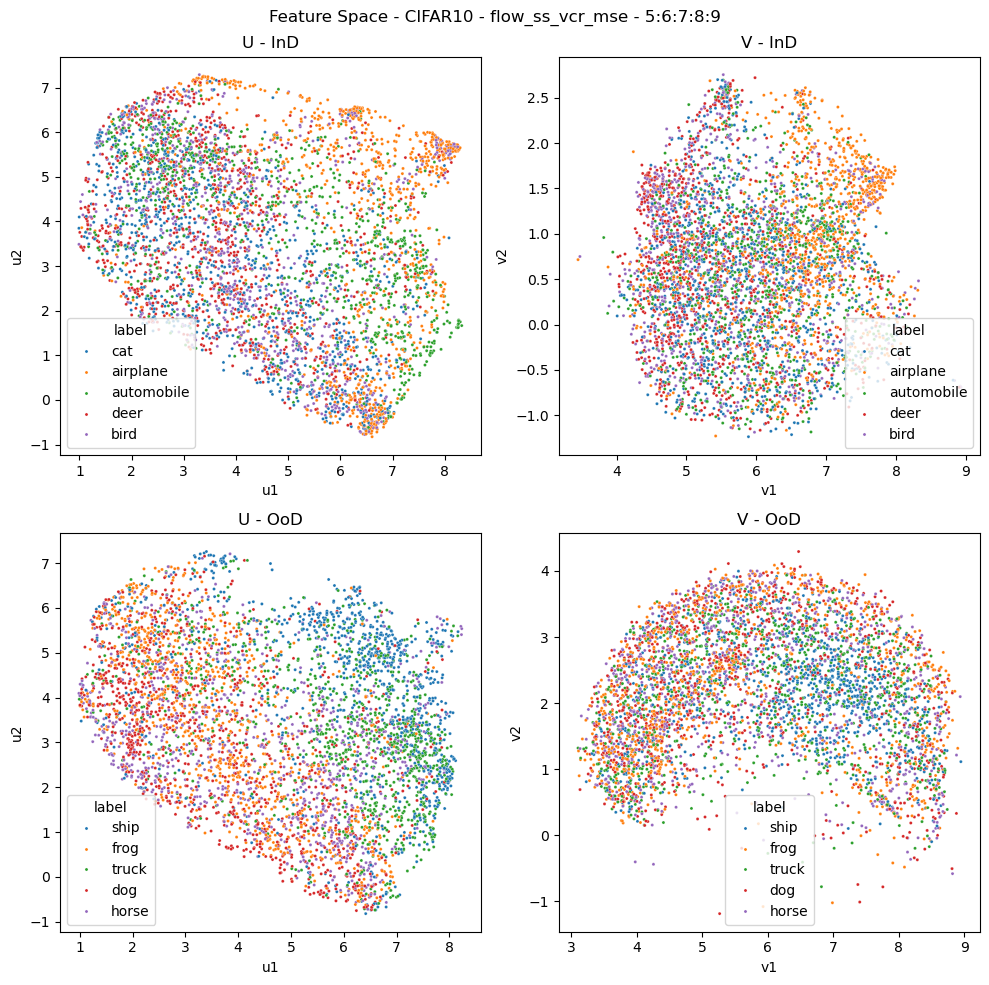

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

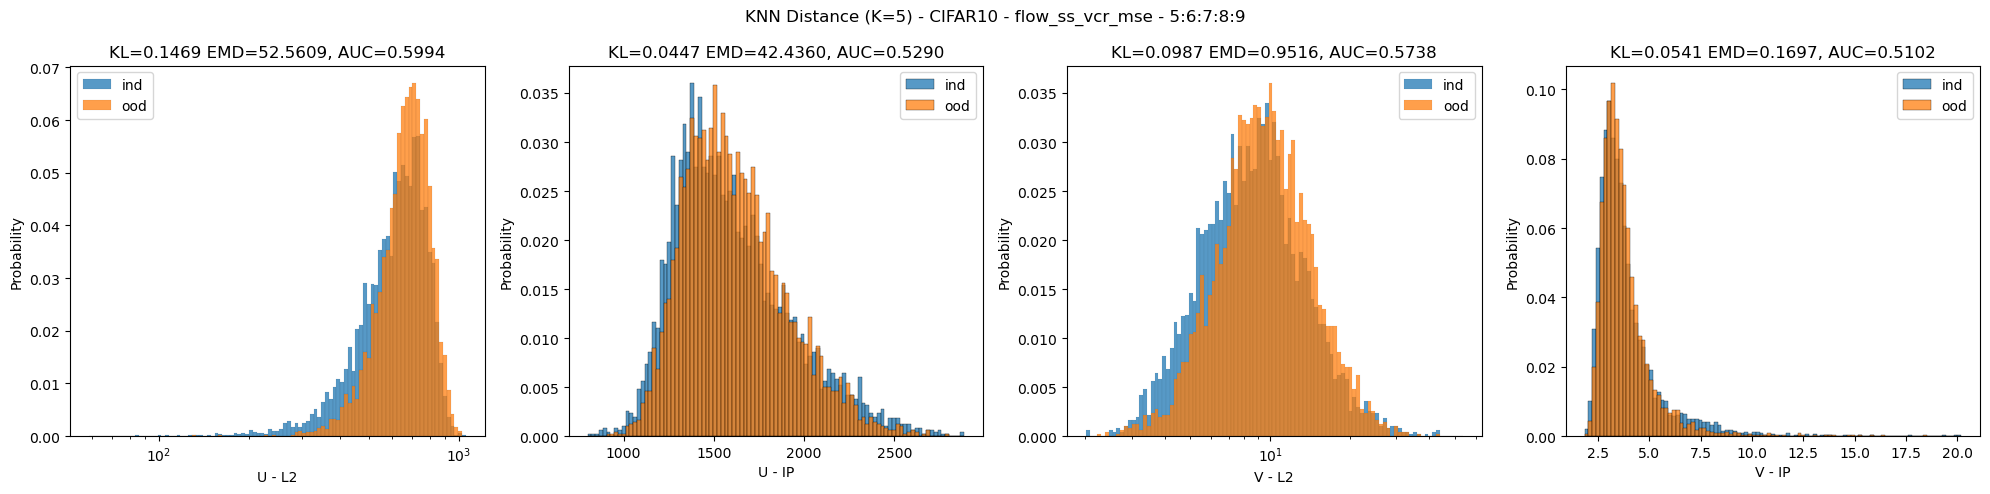

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

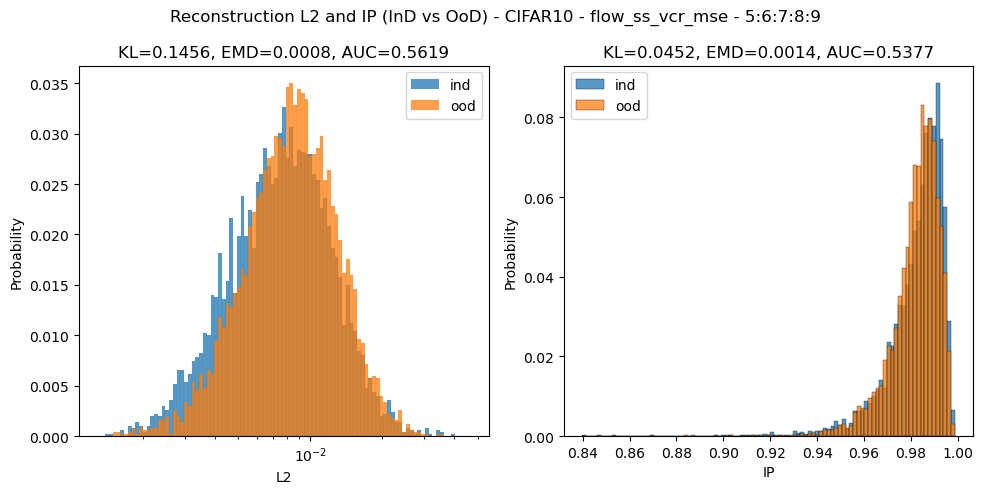

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

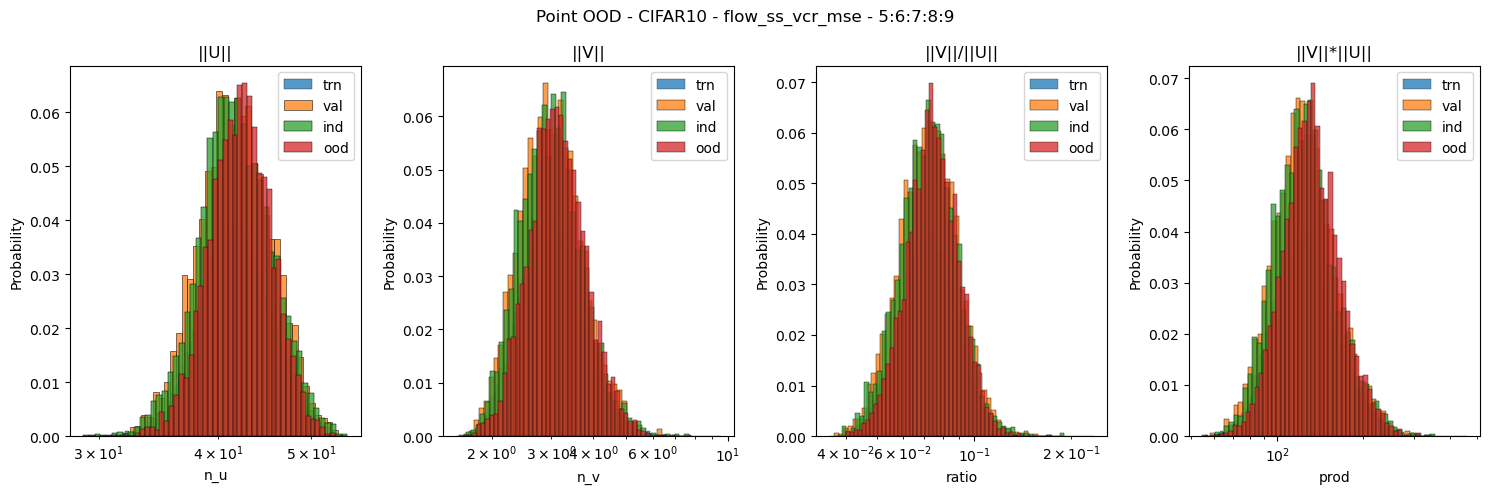

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


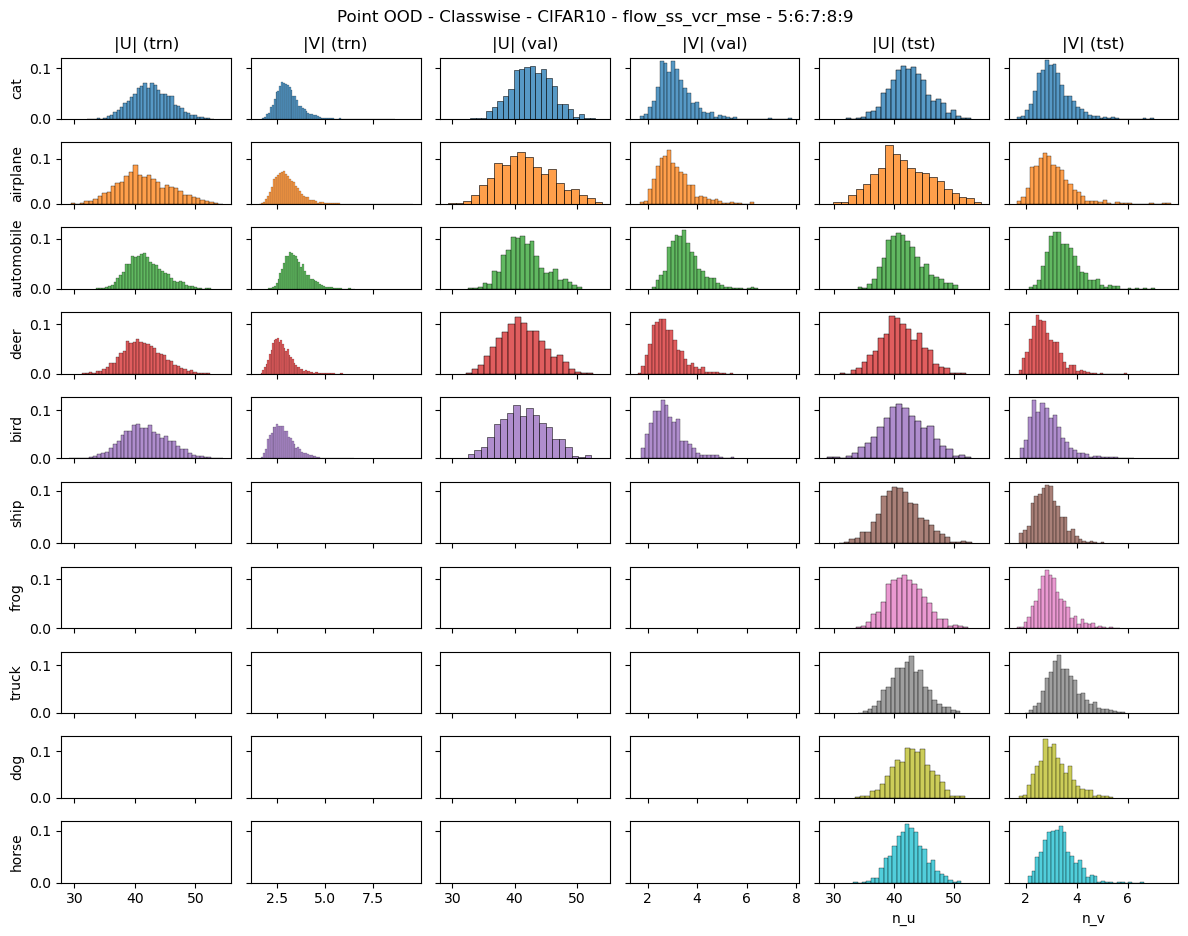

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

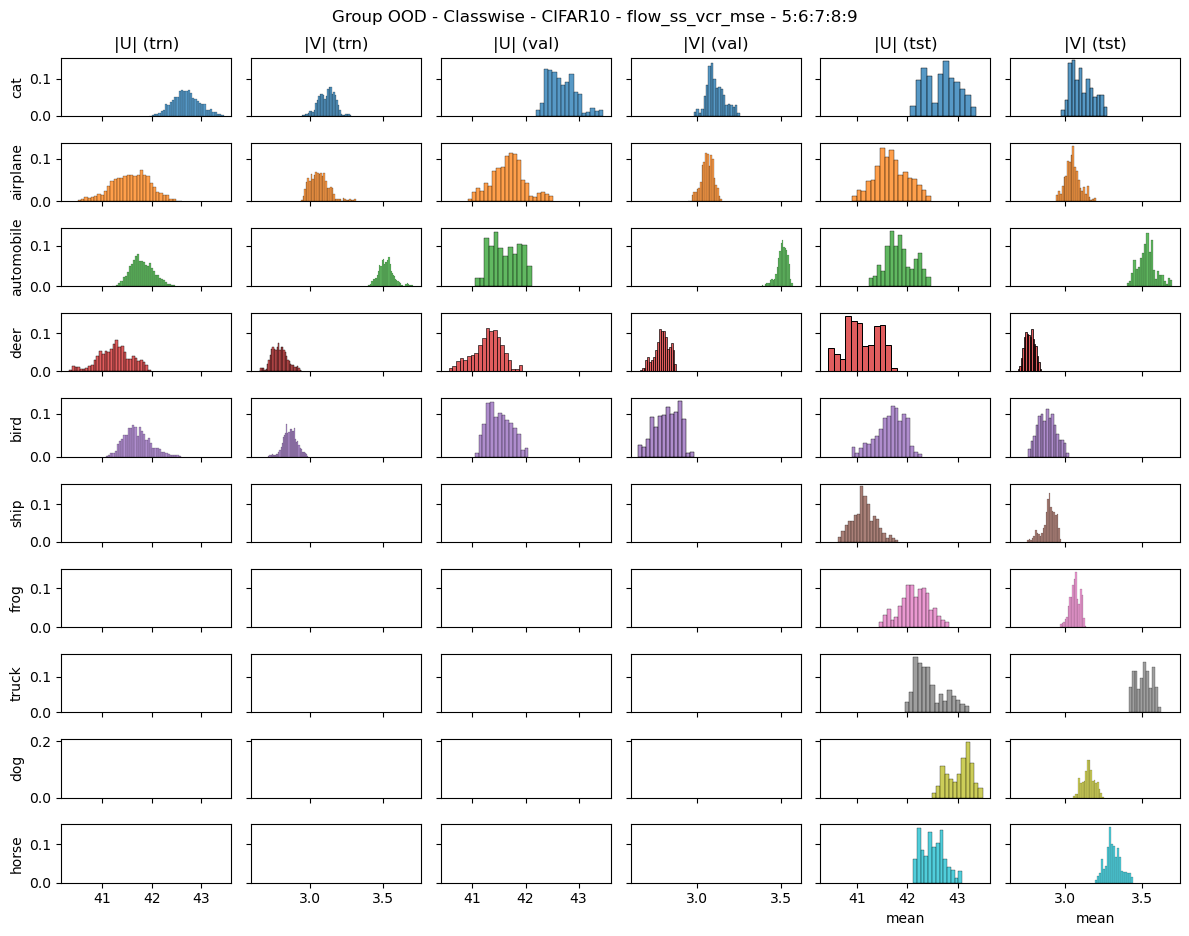

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)